<h3>importing libraries</h3>

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

<h5>read data and explore it </h5>

In [3]:
data=pd.read_csv("Your_data.csv")
data.head(3)
data.info()
print(str(data.isnull().sum()))
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      159256 non-null  int64  
 1   Cholesterol     159256 non-null  int64  
 2   triglyceride    159256 non-null  int64  
 3   age             159256 non-null  int64  
 4   hearing(right)  159256 non-null  int64  
 5   hemoglobin      159256 non-null  float64
 6   LDL             159256 non-null  int64  
 7   dental caries   159256 non-null  int64  
 8   systolic        159256 non-null  int64  
 9   hearing(left)   159256 non-null  int64  
 10  eyesight(left)  159256 non-null  float64
 11  smoking         159256 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 14.6 MB
Unnamed: 0        0
Cholesterol       0
triglyceride      0
age               0
hearing(right)    0
hemoglobin        0
LDL               0
dental caries     0
systolic          0
hearing(left)

<h4> data split in train , test and validataion</h4>

In [4]:
data['log_triglyceride']=np.log(data['triglyceride'])
data.drop(data.columns[0], axis=1,inplace=True)
X=data.drop('smoking', axis=1)
Y = data['smoking']
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['smoking'])
print(train_data.shape)

(111479, 12)


<h3>feature selection</h3>
<p>information gain when ig of a feature increases it decrease uncertainlity</p>

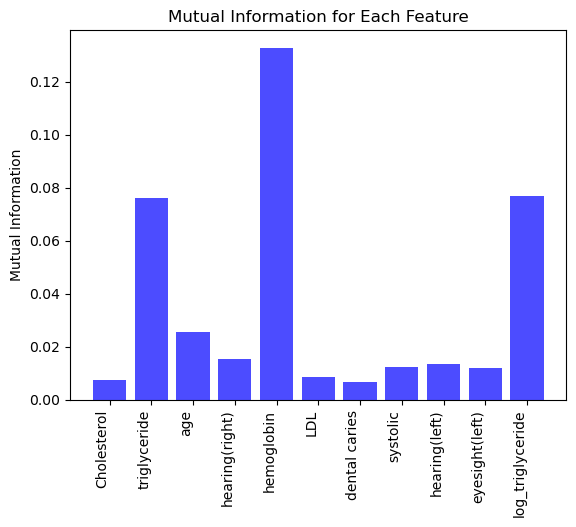

In [5]:
from sklearn.feature_selection import mutual_info_classif

ig=mutual_info_classif(X,Y)
plt.bar(np.arange(X.shape[1]), ig, color='blue', alpha=0.7)

plt.ylabel('Mutual Information')
plt.title('Mutual Information for Each Feature')

# Add feature names under each bar
plt.xticks(np.arange(X.shape[1]), X.columns, rotation=90, ha='right')

plt.show()

In [ ]:
# hemoglibin and triglyceride and log(triglyceride) because they have high information gain

<h3> remove outliers from train data by percentile</h3>
<p> test age feature</p>

In [4]:

max_threshold=train_data['age'].quantile(1)
min_threshold=train_data['age'].quantile(0)
print(max_threshold,min_threshold)
#all ages are possible ages of smokers won't remove any

85.0 20.0


<p> test LDL feature</p>

In [5]:
max_threshold = train_data['LDL'].quantile(0.999)
min_threshold = train_data['LDL'].quantile(0.001)
print(max_threshold,min_threshold)
train_data = train_data[(train_data['LDL'] < max_threshold) & (train_data['LDL'] > min_threshold)]

print(train_data.shape)

202.0 42.0
(111249, 11)


<p> test chelosterol feature</p>

In [6]:
max_threshold = train_data['Cholesterol'].quantile(0.999)
min_threshold = train_data['Cholesterol'].quantile(0.001)
print(max_threshold,min_threshold)
train_data = train_data[(train_data['Cholesterol'] < max_threshold) & (train_data['Cholesterol'] > min_threshold)]

print(train_data.shape)

283.0 118.0
(111015, 11)


<p>test systolic feature</p>

In [7]:
max_threshold = train_data['systolic'].quantile(0.999)
min_threshold = train_data['systolic'].quantile(0.001)
print(max_threshold,min_threshold)
train_data = train_data[(train_data['systolic'] < max_threshold) & (train_data['systolic'] > min_threshold)]

print(train_data.shape)

170.0 90.0
(110352, 11)


<h3>z score normalization to remove outliers</h3>
<p>  is suited for triglyceride distribution</p>

In [8]:

z_scores = zscore(train_data['triglyceride'])
z_score_threshold = 3
outliers = np.abs(z_scores) > z_score_threshold

train_data = train_data[~outliers]
print(train_data.shape)

(109205, 11)


In [9]:
#hemoglobin
z_scores = zscore(train_data['hemoglobin'])
z_score_threshold = 3
outliers = np.abs(z_scores) > z_score_threshold

train_data = train_data[~outliers]
print(train_data.shape)

(108399, 11)


In [10]:
#eyesight(left)
z_scores = zscore(train_data['eyesight(left)'])
z_score_threshold = 3
outliers = np.abs(z_scores) > z_score_threshold

train_data = train_data[~outliers]
print(train_data.shape)

(108306, 11)


<h3>splitting train,test,validate data into x and y </h3>

In [24]:

X_train=train_data.drop(['smoking'],axis=1)
Y_train=train_data['smoking']
X_test=test_data.drop(['smoking'],axis=1)
Y_test=test_data['smoking']

<h3>data normalization</h3>

In [27]:
normalizer=StandardScaler()
X_train=normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)
X = np.vstack((X_train, X_test))
print(X.shape)
Y = np.concatenate((Y_train.values, Y_test.values))
Y.shape

(156083, 10)


(156083,)

In [28]:
Y_train.value_counts()

smoking
0    60883
1    47423
Name: count, dtype: int64

In [15]:
# Train using stand alone model

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

scores = cross_val_score(DecisionTreeClassifier(), X, Y, cv=5)
scores

array([0.65765448, 0.66310023, 0.65983278, 0.65866863, 0.66030241])

In [32]:
scores.mean()

0.6599117081784958

In [33]:
# Train using Bagging

In [36]:
from sklearn.ensemble import BaggingClassifier

bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(), 
    n_estimators=100, 
    max_samples=0.8, 
    oob_score=True,
    random_state=0
)
bag_model.fit(X_train, Y_train)
bag_model.oob_score_

0.7275958857311691

In [37]:
bag_model.score(X_test, Y_test)

0.730393285472089

In [ ]:
#Boosting algorithms, on the other hand, may be more sensitive to imbalances because they focus on misclassified examples.
bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(), 
    n_estimators=100, 
    max_samples=0.8, 
    oob_score=True,
    random_state=0
)
scores = cross_val_score(bag_model, X, Y, cv=5)
scores

In [ ]:
scores.mean()

In [ ]:
# Train using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

scores = cross_val_score(RandomForestClassifier(n_estimators=50), X, y, cv=5)
scores.mean()

<h1>GRIDSEARCH</h1>
<h3>GRIDSERACH FOR BaggingClassifier</h3>

In [ ]:
from sklearn.model_selection import GridSearchCV
result = GridSearchCV(
        BaggingClassifier(),
        {
            'estimator': [DecisionTreeClassifier()],
            'n_estimators': [10, 50, 100],
            'max_samples': [0.3, 0.5, 0.8, 0.9],
            'oob_score': [True, False],
            'random_state': [0]
        },
    cv=5,
    return_train_score=False
)

result.fit(X,y)
result.cv_results_

In [ ]:
df = pd.DataFrame(result.cv_results_)
df

In [ ]:
df [['param_n_estimators','params','mean_test_score']]

<h3>Random GridSearch for Bagging</h3>

In [ ]:
from sklearn.model_selection import GridSearchCV
result = RandomizedSearchCV(
        BaggingClassifier(),
        {
            'estimator': [DecisionTreeClassifier()],
            'n_estimators': [10, 50, 100],
            'max_samples': [0.3, 0.5, 0.8, 0.9],
            'oob_score': [True, False],
            'random_state': [0]
        },
    cv=5,
    return_train_score=False
)

result.fit(X,y)
pd.DataFrame(result.cv_results_)[['param_n_estimators','params','mean_test_score']]

<h3>GRIDSERACH FOR RandomForestClassifier</h3>

In [ ]:
from sklearn.model_selection import GridSearchCV
result = GridSearchCV(
    RandomForestClassifier(), {
        'n_estimators': [1,5,10,50]
    },
    cv = 5,return_train_score = False,n_iter =2
)

result.fit(X,y)
result.cv_results_

In [ ]:
df = pd.DataFrame(result.cv_results_)
df

<h3>picking columns from tables to see score</h3>

In [ ]:
df [['param_n_estimators','params','mean_test_score']]

In [ ]:
<h2>getting best score</h2>

In [ ]:
result.best_score_

<h3>getting best parameters</h3>

In [ ]:
result.best_params_

<h2>RANDOMIZED GridSearch</h2>

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
result = RandomizedSearchCV(
    RandomForestClassifier(), {
        'n_estimators': [1,5,10,50]
    },
    cv = 5,return_train_score = False,n_iter =2  #give number of combinations of features
)

result.fit(X,y)
pd.DataFrame(result.cv_results_)[['param_n_estimators','params','mean_test_score']]
